In [1]:
import gym
import torch
import gym_nav
import numpy as np

In [90]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True, 
              'turn_speed': 0.5, 'move_speed': 15, 'max_steps': 500}
env = gym.make('NavEnv-v0', **env_kwargs)

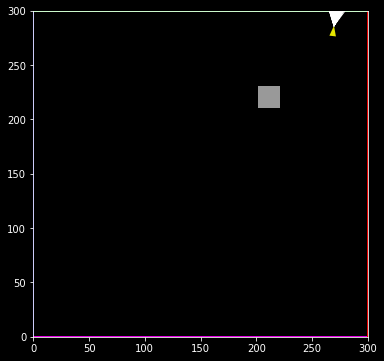

In [56]:
obs = env.reset()
env.render('human')

-0.6856505705034888


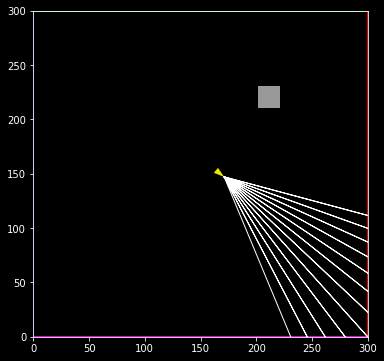

-0.6856505705034888


In [89]:
print(env.character.angle)
obs = env.step(1)
env.render('human')
print(env.character.angle)

In [43]:
from read_experiments import *

In [44]:

average_runs()

<function read_experiments.average_runs(trial_name, metric='return', ax=None, ret=False, ewm=0.01, label=None, cloud_alpha=0.1, cloud_by='minmax', ignore_first=16, color=None, medians=False, div_x_by_mil=False, ls=None, verbose=False, ignore_trial_idxs=[], skip_indexing=1)>

In [5]:
import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
%run ../evaluation 

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True}

env_kwargs = {'num_objects': 0, 'rew_structure': 'explore',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 15, 'max_steps': 500}
# model, obs_rms = torch.load('../trained_models/ppo/nav_4wallexplore/nav_4wallexplore_batch128onehot_t0.pt')
# model, obs_rms = torch.load('../saved_models/4wallexplore/nav_4wallexplore_batch128faster20m_t1.pt')
# model, obs_rms = torch.load('../saved_models/4we_aux/nav_4wallexplore_batch128faster20mrewexplore_t0.pt')
model, obs_rms = torch.load('../saved_models/4we_aux/nav_4wallexplore_batch128explorepunish_t0.pt')

res = evaluate(model, obs_rms, env_kwargs=env_kwargs, num_episodes=10, data_callback=nav_data_callback,
              verbose=2)

C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ep 0, rew tensor([[3.2300]])
ep 1, rew tensor([[0.2100]])
ep 2, rew tensor([[2.2400]])
ep 3, rew tensor([[3.2300]])
ep 4, rew tensor([[0.2100]])
ep 5, rew tensor([[2.2300]])
ep 6, rew tensor([[5.1900]])
ep 7, rew tensor([[5.2100]])
ep 8, rew tensor([[1.2300]])
ep 9, rew tensor([[0.2000]])
 Evaluation using 0 episodes: mean reward nan



C:\Users\14and\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\14and\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# !!Check whether episodes where goal is found and refound the RNN hidden state looks different. Or check whether receiving the goal reached observation makes significant change in RNN

(Figure(nrows=1, ncols=1, refwidth=2.5),
 SubplotGrid(nrows=1, ncols=1, length=1))

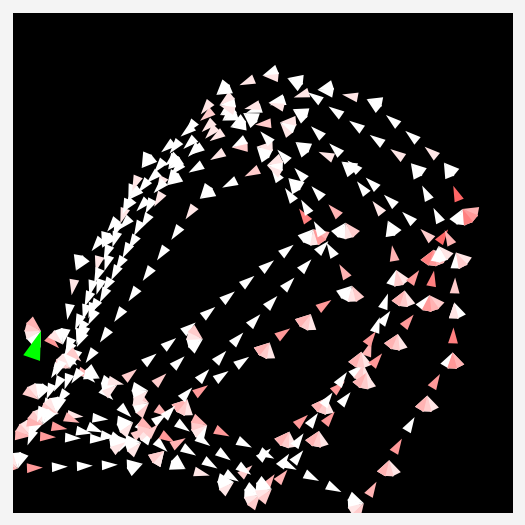

In [7]:
i = 1

pos = res['data']['pos'][i]
angle = res['data']['angle'][i]

draw_trajectory(pos, angle)

In [4]:
len(pos)

502

# Explore punish

In [2]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'explorepunish',
              'task_structure': 3, 'wall_colors': 4, 'num_rays': 12, 'fov': 1,
              'character_reset_pos': 1,  'one_hot_obs': True,
              'turn_speed': 0.5, 'move_speed': 10, 'max_steps': 500}

In [48]:
env = gym.make('NavEnv-v0', **env_kwargs)
env.reset()
# 

array([0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.28940415, 0.28497095, 0.28260

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.20375581, 0.21069753, 0.2197

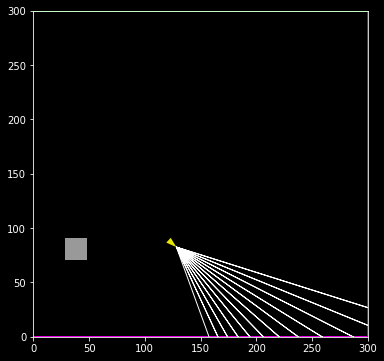

In [45]:
print(env.step(1))
env.render('human')

# Test shortcut env

In [2]:
env = gym.make('ShortcutNav-v0',  rew_structure='goal')

In [76]:
env.reset()

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.83333333, 0.83333333, 0.83333333, 1.        ,
       1.        , 1.        , 0.64146393, 0.61552929, 0.59558323,
       0.58079372, 0.57058506, 0.56457983, 0.56256345, 0.56446511,
       0.57035157, 0.58043301, 0.5950817 , 0.61486685])

(array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.83333333, 0.83333333, 0.42954463, 0.46899385, 0.52039889,
       0.58905134, 0.63030508, 0.60688545, 0.58908587, 0.57618566,
       0.56769395, 0.56330168, 0.56285329, 0.56633309]), 0, False, {'auxiliary': array([], dtype=float64)})


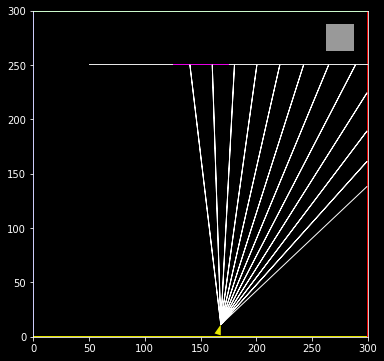

In [77]:
print(env.step(0))
env.render('human')

In [5]:
env.character.ray_dists

array([264.05469338, 273.8630102 , 259.0769037 , 247.43497454,
       238.37763417, 231.51000444, 226.55536371, 223.32585207,
       221.70421464, 221.63309706, 223.11000717, 226.18709902])

In [8]:
char = env.character


In [9]:
fov_start = char.angle - char.fov/2
fov_end = fov_start + char.fov

ray_angles = np.linspace(fov_start, fov_end, char.num_rays, endpoint=False)
ray_mults = np.array([np.cos(ray_angles), np.sin(ray_angles)]).T
ray_ends = ray_mults * char.ray_max_len + char.pos
ray_starts = np.full((char.num_rays, 2), char.pos)

x1 = ray_starts[:, 0].reshape(-1, 1)
y1 = ray_starts[:, 1].reshape(-1, 1)
x2 = ray_ends[:, 0].reshape(-1, 1)
y2 = ray_ends[:, 1].reshape(-1, 1)

#Compute intersect metrics
epsilon = 1e-8
denom = (char.y4-char.y3)*(x2-x1) - (char.x4-char.x3)*(y2-y1) + 1e-8
ua = ((char.x4-char.x3)*(y1-char.y3) - (char.y4-char.y3)*(x1-char.x3)) / denom
ub = ((x2-x1)*(y1-char.y3) - (y2-y1)*(x1-char.x3)) / denom

#Compute x y intersects (they ARE both supposed to be ua)
x = x1 + ua*(x2-x1)
y = y1 + ua*(y2-y1)

#Compute distances to intersects
dists = np.sqrt((x - char.pos[0])**2 + (y - char.pos[1])**2)

#Only keep distances with valid intersects
mults = np.full(x.shape, 1.)
mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

#We get np.nan where lines are parallel which throws off the argmin
# Setting parallel to inf should fix the issue
dists[np.isnan(dists)] = np.inf

wall_idxs = np.argmin(mults*dists, axis=1)
wall_idxs2 = np.stack([np.arange(char.num_rays), wall_idxs])

# inter_x = x[wall_idxs2[0], wall_idxs2[1]]
# inter_y = y[wall_idxs2[0], wall_idxs2[1]]


In [11]:
ray_dists = dists[wall_idxs2[0], wall_idxs2[1]]
ray_colors = list(map(lambda x: x.color, char.vis_wall_refs[wall_idxs]))
